In [2]:
from sabr import SABR
from sabr_calibration import SABRCalibrator

In [3]:
from deltadex_calibration import calibrate_sabr
from deribit_parser import GetOptionMeta

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


In [5]:
import uniswap_v3_liquidity_math as uniswap_math

import importlib
importlib.reload(uniswap_math)

<module 'uniswap_v3_liquidity_math' from '/Users/kirillbogomolov/Desktop/DeltaDex-Protocol/research-branch-main/backtest/uniswap_v3_liquidity_math.py'>

In [6]:
class UniswapPosition:
    def __init__(self, lower_price, upper_price, initial_price, initial_token1_amount, period_in_years):
        self.lower_price = lower_price
        self.upper_price = upper_price
        self.initial_price = initial_price
        self.initial_token1_amount = initial_token1_amount
        self.period_in_years = period_in_years
    
    def get_tokens_amounts(self, price):
        return uniswap_math.get_tokens_amounts(initial_price = self.initial_price, 
                                lowerPrice = self.lower_price, upperPrice = self.upper_price, 
                                initial_y = self.initial_token1_amount, currentPrice = price)
    
    def get_total_value(self, price):
        x, y = self.get_tokens_amounts(price)
        return x * price + y

### Optimal option

In [191]:
class OptimalOption:
    def __init__(self, sabr_model: SABR, 
                 uniswap_position: UniswapPosition,
                 expiration: float,
                 strike: float,
                 amount: float,
                 isCall: bool = False):
        
        self.sabr_model = sabr_model
        self.uniswap_position = uniswap_position
        
        self.isCall = False
        # self.expiration = (1.01 * uniswap_position.period_in_years)
        self.expiration = expiration
        self.strike = strike
        # self.strike = (uniswap_position.lower_price * uniswap_position.upper_price) ** 0.5
        self.amount = amount
        self.initial_cost = self.amount * self.sabr_model(self.strike, 
                                                self.uniswap_position.initial_price, 
                                                self.expiration, 
                                                self.isCall)[0]
    
    def update_option_params(self, strike, expiration, amount):
        self.strike = strike
        self.expiration = expiration
        self.amount = amount
        self.initial_cost = self.amount * self.sabr_model(self.strike, 
                                                self.uniswap_position.initial_price, 
                                                self.expiration, 
                                                self.isCall)[0]
        # print(self.initial_cost)
        
    def find_optimal_option(self):
        
        # todo: make bounds being depenedent on underlying_price
        price_lower_bound = int(self.uniswap_position.initial_price / 1.5)
        price_upper_bound = int(self.uniswap_position.initial_price * 1.3)
        prices = np.array([price for price in range(price_lower_bound, price_upper_bound, 10 )]) 
        
        from scipy.optimize import minimize
        
        def _find_optimal_option(x):
            strike, expiration, amount = x
            self.update_option_params(strike, expiration, amount)
            
            initial_tv = self.uniswap_position.get_total_value(self.uniswap_position.initial_price)
            uniswap_tvs = np.array([self.uniswap_position.get_total_value(price) for price in prices])
            
            multiplication_factor = 0.95
            loss = ((self.calculate_hedged_position(prices) + 
                    uniswap_tvs - initial_tv * multiplication_factor) ** 2).mean()  
            return loss
        
        x0 = np.array([self.strike, self.expiration, self.amount])
        res = minimize(_find_optimal_option, x0, method='nelder-mead',
                       options={'xatol': 1e-8, 'disp': True})
        
        strike, expiration, amount = res.x
        
        print('strike: {}, expiration: {}, amount: {}'.format(strike, expiration, amount))
    
    
    def calculate_hedged_position(self, prices):
        
        def calculate_pnl(price, strike):
            if self.isCall == True:
                return max(price - strike, 0)
            if self.isCall == False:
                return max(strike - price, 0)
        #calculate_pnl(price, self.strike) +
        option_pnls = self.amount * np.array([ self.sabr_model(self.strike, 
                                                    price + 0.0001, # otherwise a bug appears 
                                                    (self.expiration - self.uniswap_position.period_in_years), 
                                                    self.isCall)[0] for price in prices]) - self.initial_cost
        return option_pnls
    
    def __repr__(self):
        return ("""
        isCall: {}
        expiration: {}
        strike: {}
        amount: {}
        initial cost: {} 
        ---
        uniswap_position: lower_price: {}, upper_price: {},
        initial_price: {}, period_in_years: {}
        """.format(self.isCall, 
                    self.expiration,
                    self.strike,
                    self.amount,
                    self.initial_cost,
                    self.uniswap_position.lower_price,
                    self.uniswap_position.upper_price,
                    self.uniswap_position.initial_price,
                    self.uniswap_position.period_in_years))
    

### Calibration

In [192]:
OptionMeta = GetOptionMeta()['Expiry']
expiries = list(map(lambda expiry: (expiry[:-5] + "/" + expiry[-5:-2] + "/" + expiry[-2:]), OptionMeta))


In [193]:
expiries

['3/MAR/23',
 '30/JUN/23',
 '29/DEC/23',
 '31/MAR/23',
 '17/FEB/23',
 '13/FEB/23',
 '24/FEB/23',
 '29/SEP/23',
 '12/FEB/23',
 '28/APR/23']

In [194]:
expiries.index('28/APR/23')

9

In [195]:
expiry = expiries[expiries.index('29/SEP/23')]
expiry

'29/SEP/23'

In [196]:
sabr, underlying_price = calibrate_sabr(SELECTED_EXPIRY = expiry)


/Users/kirillbogomolov/Desktop/DeltaDex-Protocol/research-branch-main/backtest/deribit_parser.py:29: RuntimeWarning:

divide by zero encountered in double_scalars



db updated 2023-02-11 13:28:03.619706


100%|███████████████████████████████████████| 500/500 [00:00<00:00, 4642.44it/s]

optimized parameters:
('alpha ', 9.06778)
('v ', 0.8731)
('beta  ', 0.63382)
('rho', 0.11659)


In [197]:
# sabr.r = 0.1

In [198]:
print(underlying_price)

1540.19


In [199]:
uniswap_position = UniswapPosition(lower_price = 1400, 
                                   upper_price = 1700,
                                   initial_price = underlying_price, 
                                   initial_token1_amount = 300,    # usdcs
                                   period_in_years = 30 / 365.25)


In [200]:
print(uniswap_position.get_total_value(uniswap_position.initial_price))
print(uniswap_position.get_tokens_amounts(uniswap_position.initial_price))

610.0858675670702
(0.20132962009042402, 300.0)


In [203]:
strike = 1650
expiration_in_years = 75 / 365.25
amount = 5

In [204]:
optimal_option = OptimalOption(sabr, 
                               uniswap_position, 
                               expiration_in_years, 
                               strike, 
                               amount, 
                               isCall = False)

In [205]:
optimal_option.find_optimal_option()

/Users/kirillbogomolov/Desktop/DeltaDex-Protocol/research-branch-main/backtest/black_scholes.py:74: RuntimeWarning:

invalid value encountered in sqrt

/Users/kirillbogomolov/Desktop/DeltaDex-Protocol/research-branch-main/backtest/black_scholes.py:75: RuntimeWarning:

invalid value encountered in sqrt



Optimization terminated successfully.
         Current function value: 0.789588
         Iterations: 258
         Function evaluations: 483
strike: 1539.9941935167544, expiration: 0.09116247902343068, amount: 0.4091974897602599


In [206]:
prices = np.array([price for price in range(500, 2500, 10 )])


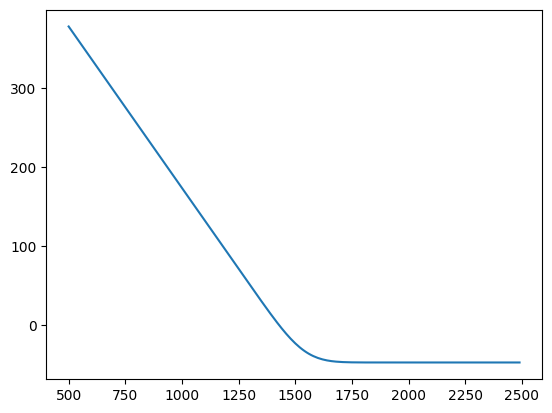

In [207]:
plt.plot(prices, optimal_option.calculate_hedged_position(prices))

In [208]:
min(optimal_option.calculate_hedged_position(prices))

-47.043852382386504

In [209]:
print(optimal_option.strike, optimal_option.uniswap_position.initial_price, optimal_option.expiration * 365)

1539.994193507516 1540.19 33.27430484240558


In [210]:
optimal_option.sabr_model(1600, 
                                                1515, 
                                                48/365.25, 
                                                False)[0]

186.78914053561562

In [211]:
optimal_option.expiration * 365.25

33.297095462160655

In [212]:
# optimal_option.sabr_model(optimal_option.strike, 
#                 underlying_price + 0.0001, 
#                 (optimal_option.expiration - optimal_option.uniswap_position.period_in_years), 
#                 optimal_option.isCall)[0]

In [213]:
optimal_option.expiration * 365.25

33.297095462160655

In [214]:
print(optimal_option)


        isCall: False
        expiration: 0.09116247902028926
        strike: 1539.994193507516
        amount: 0.409197489776152
        initial cost: 47.04385238238641 
        ---
        uniswap_position: lower_price: 1400, upper_price: 1700,
        initial_price: 1540.19, period_in_years: 0.08213552361396304
        


In [215]:
prices = np.array([price for price in range(500, 2500, 10 )])

pure_usdc = np.array([uniswap_position.get_total_value(uniswap_position.initial_price) for _ in prices])

In [216]:
optimal_option.initial_cost

47.04385238238641

In [217]:
optimal_option.expiration * 365.25

33.297095462160655

In [218]:
# optimal_option.update_option_params(optimal_option.strike, 0.08215489751882832, optimal_option.amount)

In [219]:
uniswap_tvs = np.array([uniswap_position.get_total_value(price) for price in prices])
option_pnls = optimal_option.calculate_hedged_position(prices)


In [220]:
earned_fees = 0 # in usdc

In [221]:
# pure_usdc

In [222]:
# uniswap_tvs

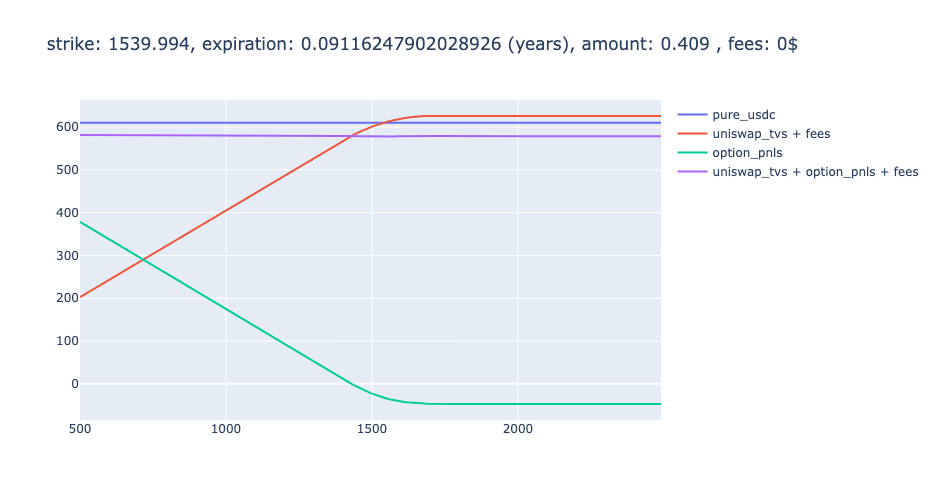

In [223]:
fig = go.Figure()
fig.update_layout(
    autosize=False,
    width=900,
    height=500)

fig.add_trace(go.Scatter(x=prices, y=pure_usdc,
                    mode='lines',
                    name='pure_usdc'))

fig.add_trace(go.Scatter(x=prices, y=uniswap_tvs + earned_fees,
                    mode='lines',
                    name="""uniswap_tvs + fees""".format(earned_fees)))
fig.add_trace(go.Scatter(x=prices, y=option_pnls,
                    mode='lines',
                    name='option_pnls'))
fig.add_trace(go.Scatter(x=prices, y=uniswap_tvs + option_pnls + earned_fees,
                    mode='lines',
                    name='uniswap_tvs + option_pnls + fees'))
fig.update_layout(title_text='strike: {}, expiration: {} (years), amount: {} , fees: {}$'.format(round(optimal_option.strike, 3), 
                                                                             optimal_option.expiration,
                                                                             round(optimal_option.amount, 3),
                                                                             earned_fees))





# Strategy 1

The range is roughly ±9%. Vault finds the optimal option and replicates it. There are two cases may appear:
1. At some point during the period, the underlying price went out of the range. In this case, vault does the rebalancing as following: <br/>
- provides liquidity to the new ±9% price range interval
- finds a new optimal option to hedge, and replicates it
2. During the entire period the underlying price stood within the boundaries. Then vault just keeps replicating the option